# Credit Card Default - Kaggle
The intention of this mini project on a classification problem is to explore the data, engineer new features, do the preprocessing, perform feature selection, build the optimized model and score it on the test data under 8 hours. I will record my lessons learned and what I could have done better for future projects at the end of the notebook.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from pandas_profiling import ProfileReport

from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier

from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import (
    cross_validate,
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import classification_report, recall_score, f1_score, precision_score, roc_auc_score

import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable("data_server")

import seaborn as sns
%matplotlib inline

<br><br>

## 1. Data - Prediction problem
<hr>


This is a classification problem of predicting whether a credit card client will default or not. For this problem, I will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. 


I will spend some time understanding the problem and what each feature means and will write a few sentences on my initial thoughts on the problem and the dataset. 

There are 25 variables:

ID: ID of each client  ----- **I will be setting this as the index.**  
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit  
SEX: Gender (1=male, 2=female)  
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)  
MARRIAGE: Marital status (1=married, 2=single, 3=others)  
AGE: Age in years  
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)  
PAY_2: Repayment status in August, 2005 (scale same as above)  
PAY_3: Repayment status in July, 2005 (scale same as above)  
PAY_4: Repayment status in June, 2005 (scale same as above)  
PAY_5: Repayment status in May, 2005 (scale same as above)  
PAY_6: Repayment status in April, 2005 (scale same as above)  
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)  
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)  
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)  
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)  
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)  
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)  
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)  
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)  
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)  
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)  
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)  
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)  


default.payment.next.month: Default payment (1=yes, 0=no)


In [2]:
credit = pd.read_csv("../downloads/UCI_Credit_Card.csv", index_col=0)

I will be renaming the target column for ease of access:

In [3]:
credit.rename({"default.payment.next.month": "default"}, axis=1, inplace=True)

There seems to be a replication of `unknown` category for `EDUCATION` column. I will replace 6's with 5's because they represent the same thing.

In [4]:
credit['EDUCATION'] = credit['EDUCATION'].replace(6, 5)

In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_0      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

There seems to be no missing data.

In [6]:
credit.isna().any(axis=0)

LIMIT_BAL    False
SEX          False
EDUCATION    False
MARRIAGE     False
AGE          False
PAY_0        False
PAY_2        False
PAY_3        False
PAY_4        False
PAY_5        False
PAY_6        False
BILL_AMT1    False
BILL_AMT2    False
BILL_AMT3    False
BILL_AMT4    False
BILL_AMT5    False
BILL_AMT6    False
PAY_AMT1     False
PAY_AMT2     False
PAY_AMT3     False
PAY_AMT4     False
PAY_AMT5     False
PAY_AMT6     False
default      False
dtype: bool

<br><br>

## 2. Data splitting 
<hr>

I am splitting the data into train and test portions with a 0.3 to 0.7 ratio due to the large size of data and my computer not being able to handle this size.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(credit.drop("default", axis=1), credit["default"], test_size=0.3, random_state=2021)

In [8]:
X_train.shape

(21000, 23)

In [9]:
y_train.shape

(21000,)

<br><br>

## 3. EDA 
<hr>




In [10]:
X_train.describe(include="all")

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000
mean,167375.222857,1.606381,1.851095,1.550429,35.546429,-0.021238,-0.135476,-0.169857,-0.225286,-0.269476,...,4.703834e+04,43065.898238,40209.465762,38800.426952,5649.285333,6.038354e+03,5101.991190,4867.827000,4744.453667,5169.922857
std,129509.677738,0.488564,0.781939,0.522032,9.277255,1.116708,1.194252,1.195877,1.168323,1.135851,...,6.969070e+04,63931.468209,60789.050230,59323.328636,16904.074480,2.527147e+04,16630.423665,16114.912307,15135.255464,17620.630792
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-4.612700e+04,-81334.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2.651000e+03,2279.500000,1715.000000,1214.000000,1000.000000,8.360000e+02,390.000000,291.000000,233.500000,99.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.007600e+04,18935.500000,18013.500000,16918.500000,2112.500000,2.004500e+03,1791.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.003325e+04,53910.750000,49901.750000,48904.000000,5019.000000,5.000000e+03,4500.000000,4003.000000,4003.000000,4000.000000
max,780000.000000,2.000000,5.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,1.664089e+06,572805.000000,823540.000000,568638.000000,873552.000000,1.684259e+06,889043.000000,621000.000000,426529.000000,528666.000000


In [11]:
y_train.value_counts(normalize=True)

0    0.778286
1    0.221714
Name: default, dtype: float64

In [12]:
train_df = pd.concat([X_train, y_train], axis=1)

train_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
13391,60000.0,1,2,2,25,2,2,2,0,0,...,13695.0,17598.0,17472.0,2017.0,5.0,1000.0,5000.0,1000.0,603.0,1
26836,170000.0,1,1,1,40,0,0,0,0,2,...,106882.0,99917.0,97133.0,6043.0,4037.0,10019.0,9.0,3480.0,4635.0,0
21939,90000.0,2,2,2,27,0,0,2,0,0,...,82784.0,53609.0,49048.0,12500.0,2.0,5085.0,5000.0,3000.0,1004.0,1
9475,190000.0,2,2,1,33,0,0,0,0,0,...,142569.0,141733.0,142982.0,8007.0,8000.0,8000.0,5500.0,5339.0,5058.0,0
16846,50000.0,1,2,1,40,1,2,0,0,0,...,49577.0,17063.0,17634.0,0.0,2058.0,1400.0,762.0,1000.0,650.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,10000.0,1,5,1,43,-1,0,0,0,-2,...,0.0,0.0,0.0,2537.0,1000.0,0.0,0.0,0.0,0.0,1
17537,160000.0,2,2,2,42,-1,-1,-1,-1,-1,...,552.0,19367.0,-1.0,40991.0,2252.0,553.0,19425.0,0.0,649.0,0
6202,260000.0,1,1,1,38,-1,-1,-1,-1,-1,...,1175.0,888.0,4186.0,1211.0,6818.0,1180.0,892.0,4207.0,6175.0,1


The target seems unbalanced (23% to 77%), but it is not very bad to force us to use balanced models. However, we could include balancing as a hyperparameter to optimize in our models.


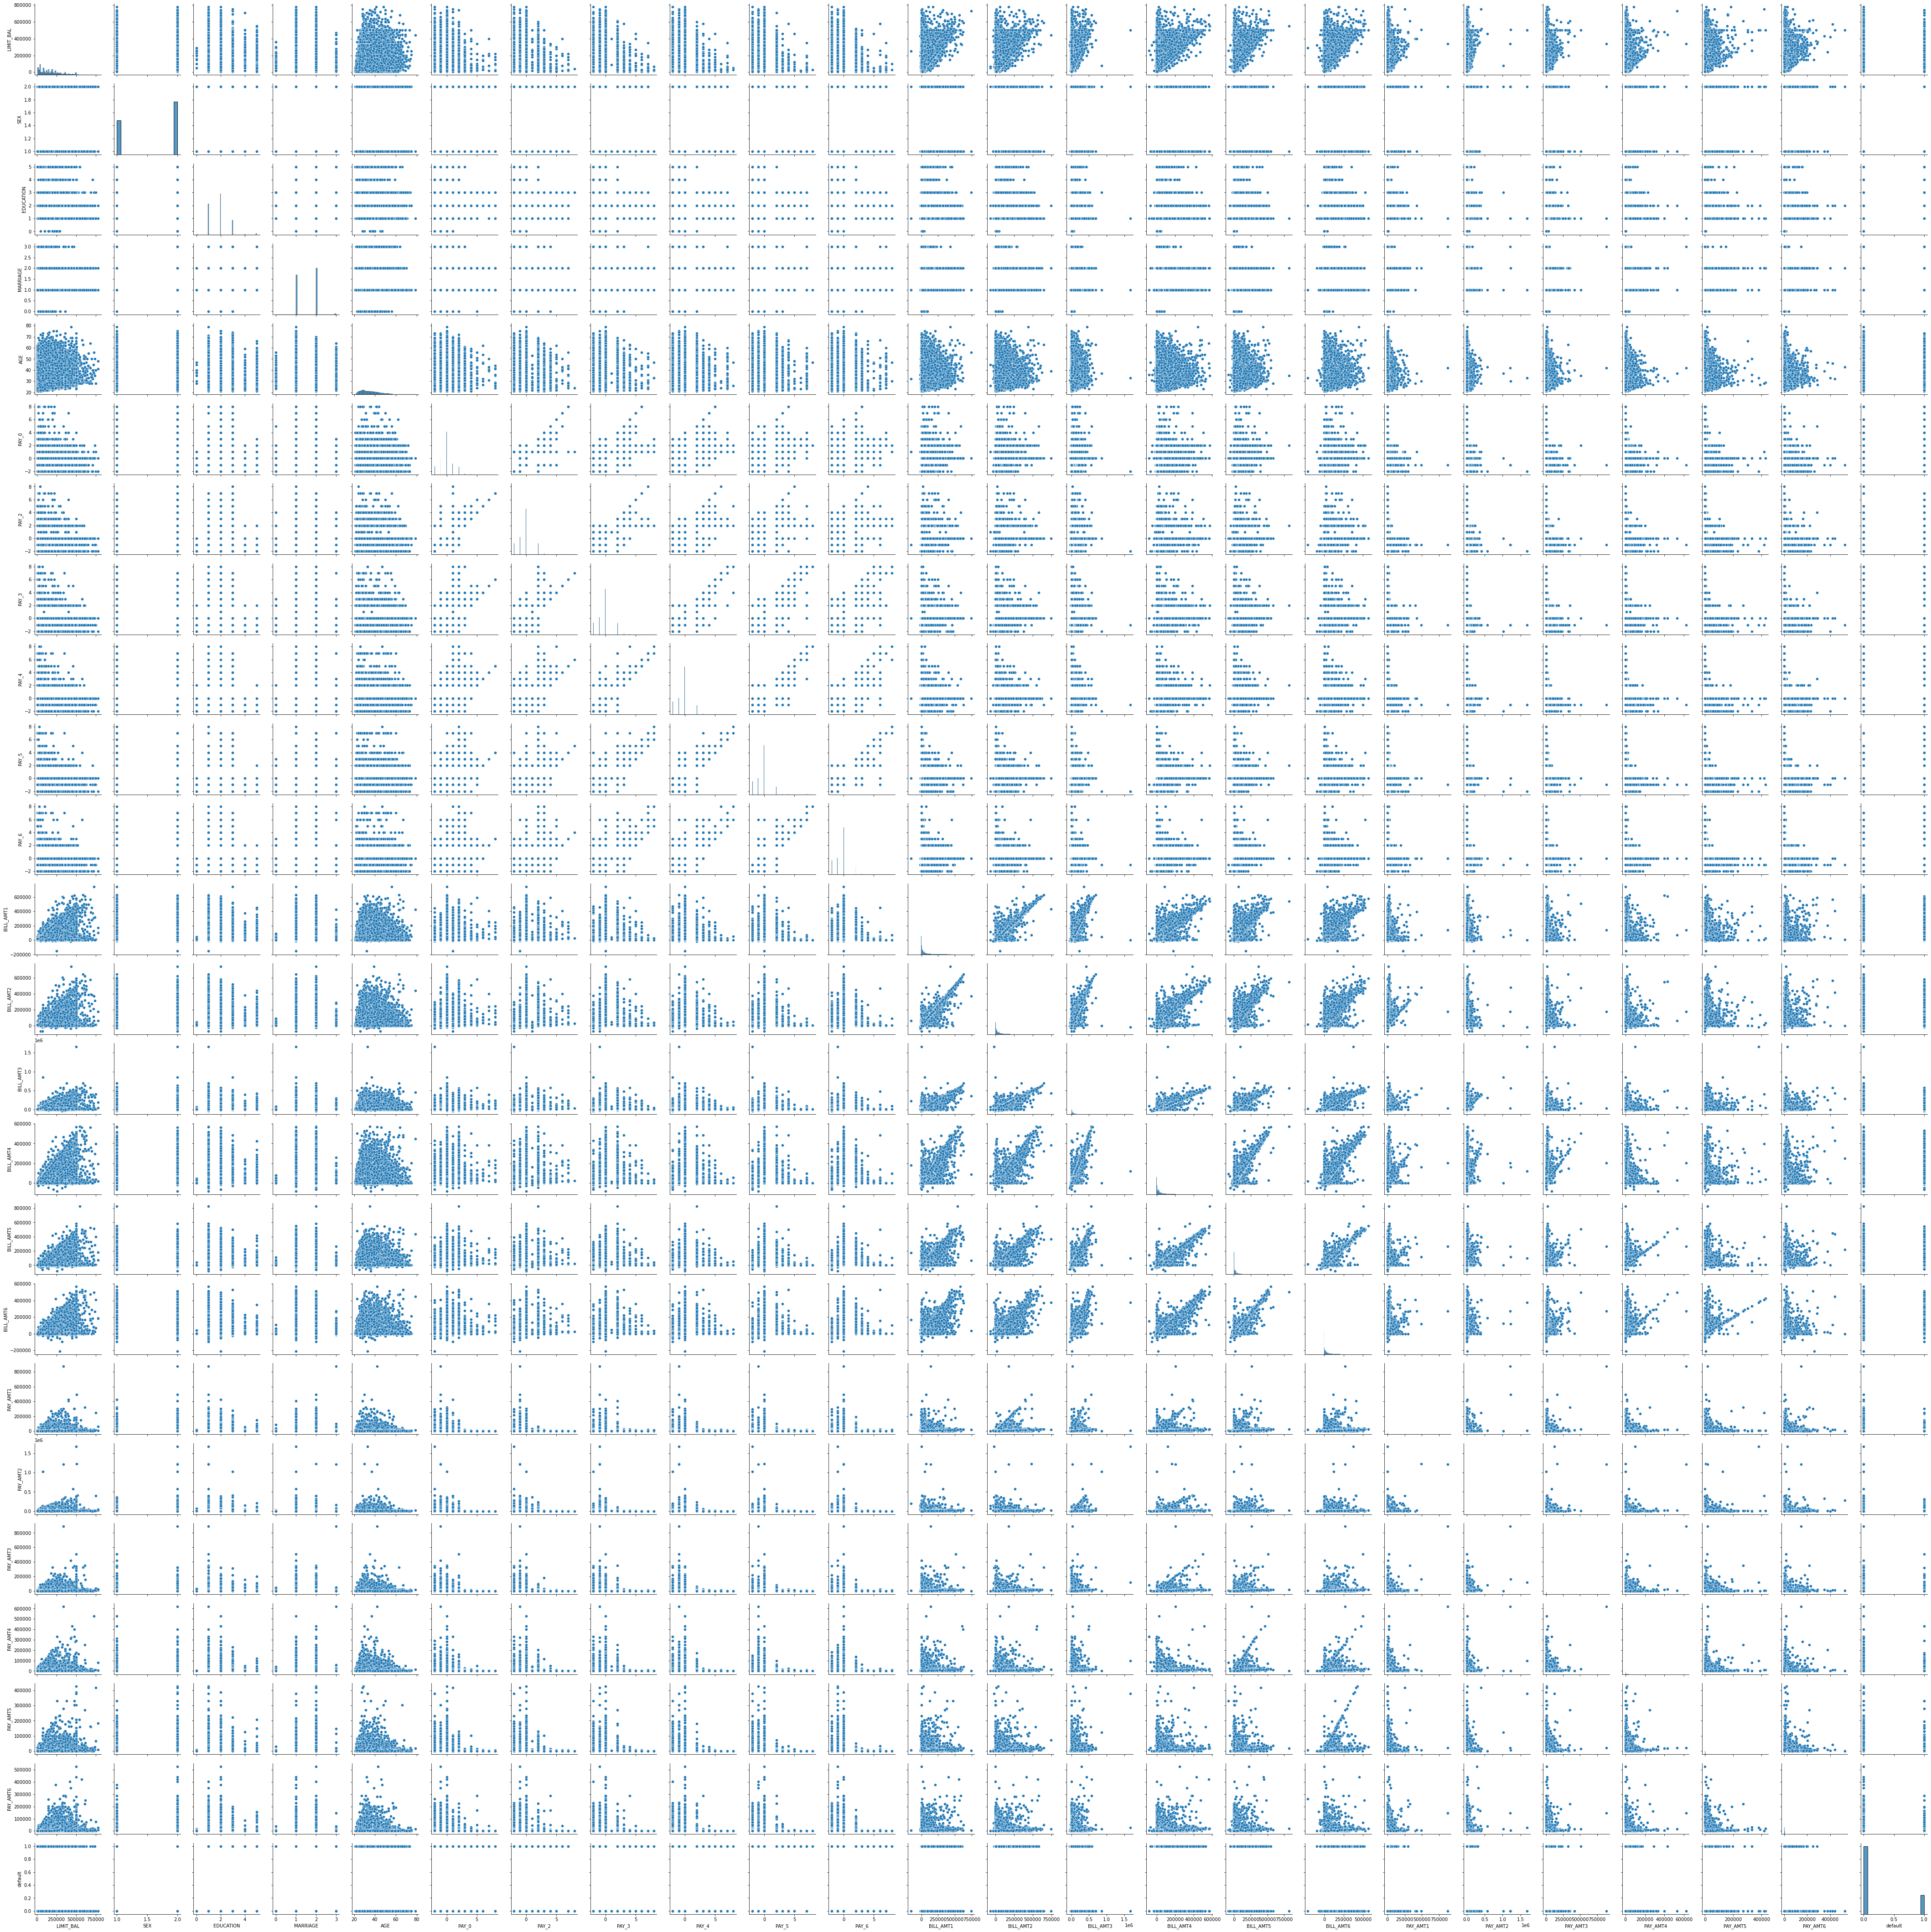

In [13]:
train_df = pd.concat([X_train, y_train], axis=1)
sns.pairplot(train_df)

This is very hard to see, but what is important is that there are some collinearity between some of these features (e.g. PAY_0 to PAY_5), and we need to be using regularization to overcome this.

Next I will see the distribution of all numeri

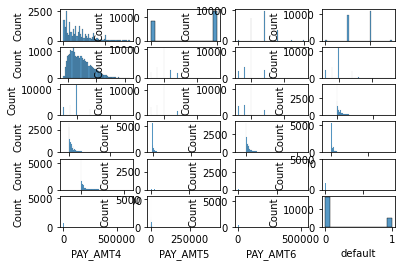

In [14]:
import matplotlib.pyplot as plt
nrows=6
ncols=4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

for i, column in enumerate(train_df.columns):
    sns.histplot(train_df[column],ax=axes[i//ncols,i%ncols])

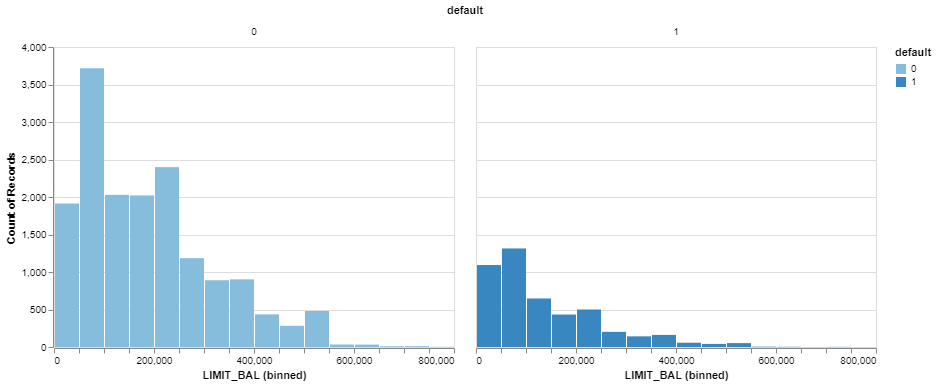

In [15]:
columns = train_df.columns.tolist()

alt.Chart(train_df).mark_bar().encode(
    x=alt.X('LIMIT_BAL', bin=alt.Bin(maxbins=20)),
    y=alt.Y('count()'),
    color='default:O'
).facet('default')

LIMIT_BAL which is the amount of credit given seems to be very right-skewed.

- The skewedness of data will cause the regression line to not best represent the underlying weights, and it might be necessary to use L1 (absolute mean error) as the cost function instead of L2 (root mean square error) to minimize the effect of penalizing squared differences. Some columns including id (already used as index) could be dropped. 

### Scoring Metric
- One might argue that they will be picking recall as their metric for this analysis since for the case of credit card default detection we want to increase the percentage of prediction of default cases (True positive) over all cases which will truly default in the future (True positive + False negative). However, I am picking accuracy over recall because for a credit bureau it is also important not to lose customer, and therefore, they need to keep both True Positive (TP) and True Negative (TN) at maximum.

In [16]:
scoring = 'accuracy'  # (TP + TN) / all

<br><br>

## 4. Feature engineering 
<hr>


I am creating six extra columns by dividing Amount of bill statement (`BILL_PCT#`) per month over the amount of given credit to each person (`LIMIT_BAL`) to see if the percentage over or under the credit limit would trigger any behaviour on the target population, and therefore, predict future credit defaults.

In [17]:
for i in range(1, 7):
    X_train['BILL_PCT' + str(i)] = X_train["BILL_AMT" + str(i)] / X_train['LIMIT_BAL']

I am also creating a `AVG_LATE` feature which will average the number of late months.

In [18]:
X_train['AVG_LATE'] = X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].sum(axis=1) / 6

In [19]:
X_train.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_PCT1,BILL_PCT2,BILL_PCT3,BILL_PCT4,BILL_PCT5,BILL_PCT6,AVG_LATE
ID,,,,,,,,,,,,,,,,,,,,,
13391,60000.0,1,2,2,25,2,2,2,0,0,...,5000.0,1000.0,603.0,0.601500,0.368050,0.257400,0.228250,0.293300,0.291200,1.000000
26836,170000.0,1,1,1,40,0,0,0,0,2,...,9.0,3480.0,4635.0,0.931329,0.702506,0.641976,0.628718,0.587747,0.571371,0.333333
21939,90000.0,2,2,2,27,0,0,2,0,0,...,5000.0,3000.0,1004.0,1.088589,1.116022,0.991578,0.919822,0.595656,0.544978,0.333333


<br><br>

## 5. Preprocessing and transformations
<hr>


I am identifying different feature types and the transformations I would apply on each feature type, and will then define a column transformer.

In [20]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_PCT1',
       'BILL_PCT2', 'BILL_PCT3', 'BILL_PCT4', 'BILL_PCT5', 'BILL_PCT6',
       'AVG_LATE'],
      dtype='object')

In [21]:
credit['PAY_2'].unique()

array([ 2,  0, -1, -2,  3,  5,  7,  4,  1,  6,  8], dtype=int64)

In [22]:
drop = []
categorical = [
    "SEX",
    "EDUCATION",
    "MARRIAGE",
    "PAY_0",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6",
]  # values of PAY_# are between -2 to 9
numeric = [
    "LIMIT_BAL",
    "AGE",
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
    "PAY_AMT1",
    "PAY_AMT2",
    "PAY_AMT3",
    "PAY_AMT4",
    "PAY_AMT5",
    "PAY_AMT6",
]
passthrough = [
    "BILL_PCT1",
    "BILL_PCT2",
    "BILL_PCT3",
    "BILL_PCT4",
    "BILL_PCT5",
    "BILL_PCT6",
    'AVG_LATE'
]  

assert len(drop + categorical + numeric + passthrough) == len(X_train.columns.tolist())

In [23]:
preprocessor = make_column_transformer(
    ("drop", drop),
    (OneHotEncoder(handle_unknown="ignore"), categorical),
    (StandardScaler(),numeric),
    ("passthrough", passthrough)
)

<br><br>

## 6. Baseline model 
<hr>

1. Try `scikit-learn`'s baseline model and report results.

In [24]:

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    from MDS lecture
    
    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [25]:
results = dict()

dummy_pipe = make_pipeline(preprocessor, DummyClassifier())
results["Dummy Classifier"] = mean_std_cross_val_scores(dummy_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

,Dummy Classifier
fit_time,0.040 (+/- 0.004)
score_time,0.011 (+/- 0.001)
test_score,0.778 (+/- 0.000)
train_score,0.778 (+/- 0.000)


<br><br>

## 7. Linear models 
<hr>

I will try a linear model as a first real attempt. I will then carry out hyperparameter tuning to explore different values for the regularization hyperparameter. Finally I will report cross-validation scores along with standard deviation and a summary of results.

In [26]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=2021))
results["Logistic Regression"] = mean_std_cross_val_scores(lr_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

,Dummy Classifier,Logistic Regression
fit_time,0.040 (+/- 0.004),0.991 (+/- 0.171)
score_time,0.011 (+/- 0.001),0.013 (+/- 0.002)
test_score,0.778 (+/- 0.000),0.818 (+/- 0.004)
train_score,0.778 (+/- 0.000),0.820 (+/- 0.001)


In [27]:
lr_params = {
    "logisticregression__C": list(np.logspace(-3,3,7)),
    "logisticregression__class_weight": ['balanced', None]
}
hyper_lr = GridSearchCV(lr_pipe, param_grid=lr_params, scoring=scoring, cv=5, return_train_score=True)

In [28]:
hyper_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('drop',
                                                                         'drop',
                                                                         []),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['SEX',
                                                                          'EDUCATION',
                                                                          'MARRIAGE',
                                                                          'PAY_0',
                                                                          'PAY_2',
                                                         

In [29]:
hyper_lr.best_params_

{'logisticregression__C': 100.0, 'logisticregression__class_weight': None}

In [30]:
hyper_lr.best_score_

0.8184285714285714

In [31]:
best_C = hyper_lr.best_params_['logisticregression__C']
best_class_weight = hyper_lr.best_params_['logisticregression__class_weight']

tuned_lr = make_pipeline(preprocessor, LogisticRegression(random_state=2021, max_iter=2000, C=best_C, class_weight=best_class_weight))
results["Tuned Logistic Reg"] = mean_std_cross_val_scores(tuned_lr, X_train, y_train, return_train_score=True, cv=5, scoring=scoring)
pd.DataFrame(results)

,Dummy Classifier,Logistic Regression,Tuned Logistic Reg
fit_time,0.040 (+/- 0.004),0.991 (+/- 0.171),2.316 (+/- 0.514)
score_time,0.011 (+/- 0.001),0.013 (+/- 0.002),0.016 (+/- 0.003)
test_score,0.778 (+/- 0.000),0.818 (+/- 0.004),0.818 (+/- 0.004)
train_score,0.778 (+/- 0.000),0.820 (+/- 0.001),0.821 (+/- 0.002)


_According to the above, although our hyperparameter tuning has selected a C value of 10 over the default value of 1, we can see that the crossvalidation score (`test_score` in the table above) has not improved._

<br><br>

## 8. Different models 
<hr>

I will try 3 other models aside from a linear model. I will summarize my results in terms of overfitting/underfitting and fit and score times to see if I can beat a linear model.

- Since the size of the data is not very big (<100K) and our dataframe is dense (not sparse) I will give SVM a try to see if it can identify any non-linear patterns. 
- I won't be using Naive Bayes model for this exercise. The major weakness of NB is that the predictive accuracy is highly correlated with the assumption of class conditional independence. This assumption simplifies computation. In the case of this dataset, however, dependencies exist between multiple variables. 
- I will be using Random forest as a catch all for decision trees.
- Between LGBM classifier and Catboost classifier, I will also try both and pick one for further hyperparameter tuning.

Note: Running this cell will take upwards of 5 minutes.

In [32]:
models = {
    "SVC": make_pipeline(preprocessor, SVC(kernel='rbf')),
    "Random Forest": make_pipeline(
        preprocessor, RandomForestClassifier(random_state=2021)
    ),
    "LGBM": make_pipeline(
        preprocessor,
        LGBMClassifier(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
        ),
    ),
}

for name, model in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, cv=5, scoring=scoring
    )

pd.DataFrame(results)

,Dummy Classifier,Logistic Regression,Tuned Logistic Reg,SVC,Random Forest,LGBM
fit_time,0.040 (+/- 0.004),0.991 (+/- 0.171),2.316 (+/- 0.514),26.324 (+/- 1.251),3.792 (+/- 0.045),0.353 (+/- 0.005)
score_time,0.011 (+/- 0.001),0.013 (+/- 0.002),0.016 (+/- 0.003),5.036 (+/- 0.256),0.104 (+/- 0.009),0.030 (+/- 0.003)
test_score,0.778 (+/- 0.000),0.818 (+/- 0.004),0.818 (+/- 0.004),0.818 (+/- 0.006),0.813 (+/- 0.004),0.816 (+/- 0.005)
train_score,0.778 (+/- 0.000),0.820 (+/- 0.001),0.821 (+/- 0.002),0.824 (+/- 0.002),1.000 (+/- 0.000),0.853 (+/- 0.002)


I have not been able to beat the linear model (Logistic Regression) using the three new models. In terms of fit time and performance LGBM Classifier seems to be the best of the three added models followed by Random Forest and I will choose both for further tuning and ensemble models. SVC and Random Forest have very long fit times, and when it comes to scoring time, SVC is the the worst of all as expected. Seeing that none of the three added models come close to the score time and CV score (test_score) for Logistic Regression, it would not be rational to use any of these 3 new models unless they improve massively when optimized.  
There are signs of overfitting for Random forest as the train score is 1 and its gap with CV score has increased tremendously. This is mainly due to not having max_depth for decision trees which could potentially be optimized through hyperparameter optimization.

Next, I will try a voting and stacking classifier to see if I see any improvements:

In [33]:
estimators = [
    ("logistic_regression", LogisticRegression(max_iter=2000, random_state=2021)),
    ("random_forest", RandomForestClassifier(random_state=2021)),
    (
        "LGBM",
        LGBMClassifier(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
        ),
    ),
]

# defining voting pipe
voting_classifier = VotingClassifier(estimators=estimators, voting="hard")
vote_pipe = make_pipeline(preprocessor, voting_classifier)

# Calculating cross validation results
results["Voting"] = mean_std_cross_val_scores(
    vote_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring
)
pd.DataFrame(results)

,Dummy Classifier,Logistic Regression,Tuned Logistic Reg,SVC,Random Forest,LGBM,Voting
fit_time,0.040 (+/- 0.004),0.991 (+/- 0.171),2.316 (+/- 0.514),26.324 (+/- 1.251),3.792 (+/- 0.045),0.353 (+/- 0.005),4.890 (+/- 0.134)
score_time,0.011 (+/- 0.001),0.013 (+/- 0.002),0.016 (+/- 0.003),5.036 (+/- 0.256),0.104 (+/- 0.009),0.030 (+/- 0.003),0.233 (+/- 0.013)
test_score,0.778 (+/- 0.000),0.818 (+/- 0.004),0.818 (+/- 0.004),0.818 (+/- 0.006),0.813 (+/- 0.004),0.816 (+/- 0.005),0.819 (+/- 0.004)
train_score,0.778 (+/- 0.000),0.820 (+/- 0.001),0.821 (+/- 0.002),0.824 (+/- 0.002),1.000 (+/- 0.000),0.853 (+/- 0.002),0.857 (+/- 0.002)


In [34]:
# List of estimators is acquired from above
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(
        max_iter=2000,
        random_state=2021,
    ),
    cv=5,
)

# Calculating cross validation results
stacking_pipe = make_pipeline(preprocessor, stacking_classifier)
results["Stacking"] = mean_std_cross_val_scores(
    stacking_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring
)
pd.DataFrame(results)

,Dummy Classifier,Logistic Regression,Tuned Logistic Reg,SVC,Random Forest,LGBM,Voting,Stacking
fit_time,0.040 (+/- 0.004),0.991 (+/- 0.171),2.316 (+/- 0.514),26.324 (+/- 1.251),3.792 (+/- 0.045),0.353 (+/- 0.005),4.890 (+/- 0.134),24.575 (+/- 0.928)
score_time,0.011 (+/- 0.001),0.013 (+/- 0.002),0.016 (+/- 0.003),5.036 (+/- 0.256),0.104 (+/- 0.009),0.030 (+/- 0.003),0.233 (+/- 0.013),0.158 (+/- 0.022)
test_score,0.778 (+/- 0.000),0.818 (+/- 0.004),0.818 (+/- 0.004),0.818 (+/- 0.006),0.813 (+/- 0.004),0.816 (+/- 0.005),0.819 (+/- 0.004),0.818 (+/- 0.004)
train_score,0.778 (+/- 0.000),0.820 (+/- 0.001),0.821 (+/- 0.002),0.824 (+/- 0.002),1.000 (+/- 0.000),0.853 (+/- 0.002),0.857 (+/- 0.002),0.872 (+/- 0.004)


Seeing the similar performance of stacking classifier one might get tempted to select this ensemble for further feature selection and hyperparameter optimization. However, I would go with Voting Classifier due to faster fit time and not much difference in cross validation (test) score. What is also critical to observe is that the stacking model is overfitting more than voting classifier because of the larger gap between development (cross validation) score and train score.
<br><br>

## 9. Feature selection 
<hr>

I am making some attempts to select relevant features. I won't be trying recursive `RFECV` for this because the voting classifier is already slow. Instead, I will SelectFromModel using Logistic Regression with L1 regularization as a step to select smaller number of features. note that the solver needs to be changed to something like liblinear to allow for the optimizer to work (the default lgbfs solver does not work for L1 regularization). I am setting the reverse of regularization term (C) to a small number to penalize coefficients and force majority of them to zero (increase regularization).

In [35]:
feat_select_pipe = make_pipeline(
    preprocessor,
    SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=2021)),
    voting_classifier
)

results["Voting Feat. Select"] = mean_std_cross_val_scores(
    feat_select_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring
)
pd.DataFrame(results)

,Dummy Classifier,Logistic Regression,Tuned Logistic Reg,SVC,Random Forest,LGBM,Voting,Stacking,Voting Feat. Select
fit_time,0.040 (+/- 0.004),0.991 (+/- 0.171),2.316 (+/- 0.514),26.324 (+/- 1.251),3.792 (+/- 0.045),0.353 (+/- 0.005),4.890 (+/- 0.134),24.575 (+/- 0.928),3.549 (+/- 0.394)
score_time,0.011 (+/- 0.001),0.013 (+/- 0.002),0.016 (+/- 0.003),5.036 (+/- 0.256),0.104 (+/- 0.009),0.030 (+/- 0.003),0.233 (+/- 0.013),0.158 (+/- 0.022),0.283 (+/- 0.021)
test_score,0.778 (+/- 0.000),0.818 (+/- 0.004),0.818 (+/- 0.004),0.818 (+/- 0.006),0.813 (+/- 0.004),0.816 (+/- 0.005),0.819 (+/- 0.004),0.818 (+/- 0.004),0.818 (+/- 0.005)
train_score,0.778 (+/- 0.000),0.820 (+/- 0.001),0.821 (+/- 0.002),0.824 (+/- 0.002),1.000 (+/- 0.000),0.853 (+/- 0.002),0.857 (+/- 0.002),0.872 (+/- 0.004),0.852 (+/- 0.001)


In [36]:
feat_select_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('drop', 'drop', []),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEX', 'EDUCATION',
                                                   'MARRIAGE', 'PAY_0', 'PAY_2',
                                                   'PAY_3', 'PAY_4', 'PAY_5',
                                                   'PAY_6']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',...
 

In [37]:
feat_select_pipe.named_steps['selectfrommodel'].n_features_in_

96

In [38]:
feat_select_pipe.named_steps['votingclassifier'].n_features_in_

33

With the above feature selection technique, I have reduced the number of input features to a third (from 96 to 33) by keeping the same crossvalidation score while reducing the fit time. This will make the next step, hyperparameter optimzation, very faster.

<br><br>

## 10. Hyperparameter optimization
<hr>
I will be referencing the same feat_select_pipe as above for this section.

In [39]:
hyper_params = {
    "votingclassifier__logistic_regression__C": np.logspace(-4, 2, 7),
    "votingclassifier__logistic_regression__class_weight": ['balanced', None],
    "votingclassifier__random_forest__max_depth": 5 * np.arange(1, 6,),
    "votingclassifier__random_forest__class_weight": ['balanced', None],
    "votingclassifier__LGBM__learning_rate": [0.05, 0.1, 0.15, 0.2],
    "votingclassifier__LGBM__n_estimators": [100, 200, 300]
}
    
tune_voting = RandomizedSearchCV(feat_select_pipe, param_distributions=hyper_params, n_iter=30, scoring=scoring, cv=5)
tune_voting.fit(X_train, y_train)
tune_voting.best_params_

{'votingclassifier__random_forest__max_depth': 15,
 'votingclassifier__random_forest__class_weight': None,
 'votingclassifier__logistic_regression__class_weight': None,
 'votingclassifier__logistic_regression__C': 10.0,
 'votingclassifier__LGBM__n_estimators': 300,
 'votingclassifier__LGBM__learning_rate': 0.05}

### Iteration
I have been taking a look at the selected hyperparameter in RandomizedSearchCV, while looking at the `rank_test_score` to iteratively adjust the range for my hyperparameter.

In [40]:
pd.DataFrame(tune_voting.cv_results_).sort_values("rank_test_score").drop(
    [
        "std_fit_time",
        "std_score_time",
        "params",
        "split0_test_score",
        "split1_test_score",
        "split2_test_score",
        "split3_test_score",
        "split4_test_score",
        "std_test_score",
    ],
    axis=1,
).T

,23,7,8,12,22,25,6,18,9,15,...,26,4,27,21,28,3,16,20,11,13
mean_fit_time,4.05813,1.990524,2.847672,2.367327,2.017524,2.189267,2.34098,4.406773,1.552972,3.660599,...,3.911928,3.485451,3.528246,3.924779,3.436176,3.900077,3.312814,3.804398,2.926081,1.821067
mean_score_time,0.327091,0.227189,0.212543,0.186556,0.231074,0.245107,0.20404,0.344523,0.167936,0.282912,...,0.300286,0.292599,0.273889,0.315385,0.287071,0.331205,0.285216,0.304006,0.224984,0.208721
param_votingclassifier__random_forest__max_depth,15,5,15,10,5,5,10,25,5,20,...,25,15,15,20,20,25,15,15,15,5
param_votingclassifier__random_forest__class_weight,None,None,None,None,balanced,None,balanced,None,balanced,balanced,...,balanced,None,None,balanced,balanced,balanced,balanced,balanced,balanced,balanced
param_votingclassifier__logistic_regression__class_weight,None,None,balanced,balanced,None,None,None,None,None,None,...,None,balanced,balanced,balanced,None,balanced,balanced,balanced,balanced,balanced
param_votingclassifier__logistic_regression__C,10.0,1.0,0.0001,100.0,1.0,1.0,0.01,0.1,0.01,100.0,...,0.001,1.0,100.0,10.0,0.0001,10.0,0.001,0.01,10.0,0.01
param_votingclassifier__LGBM__n_estimators,300,300,100,100,100,200,100,300,100,300,...,100,200,300,100,200,200,300,300,100,200
param_votingclassifier__LGBM__learning_rate,0.05,0.15,0.05,0.05,0.1,0.1,0.1,0.1,0.1,0.1,...,0.2,0.2,0.1,0.1,0.2,0.2,0.2,0.1,0.15,0.1
mean_test_score,0.818429,0.818238,0.818143,0.818,0.817714,0.817619,0.817476,0.817429,0.817286,0.81719,...,0.814714,0.814667,0.814524,0.813048,0.812238,0.810571,0.807667,0.807524,0.807286,0.78919
rank_test_score,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30


In [41]:
tune_voting.best_params_

{'votingclassifier__random_forest__max_depth': 15,
 'votingclassifier__random_forest__class_weight': None,
 'votingclassifier__logistic_regression__class_weight': None,
 'votingclassifier__logistic_regression__C': 10.0,
 'votingclassifier__LGBM__n_estimators': 300,
 'votingclassifier__LGBM__learning_rate': 0.05}

In [42]:
# Setting up a tuned estimator with the above best parameters
tuned_estimators = [
    (
        "logistic_regression",
        LogisticRegression(
            max_iter=2000,
            random_state=2021,
            C=tune_voting.best_params_["votingclassifier__logistic_regression__C"],
            class_weight=tune_voting.best_params_[
                "votingclassifier__logistic_regression__class_weight"
            ],
        ),
    ),
    (
        "random_forest",
        RandomForestClassifier(
            random_state=2021,
            max_depth=tune_voting.best_params_[
                "votingclassifier__random_forest__max_depth"
            ],
            class_weight=tune_voting.best_params_[
                "votingclassifier__logistic_regression__class_weight"
            ],
        ),
    ),
    (
        "LGBM",
        LGBMClassifier(
            random_state=2021,
            verbose=0,
            force_col_wise=True,
            n_estimators=tune_voting.best_params_[
                "votingclassifier__LGBM__n_estimators"
            ],
            learning_rate=tune_voting.best_params_[
                "votingclassifier__LGBM__learning_rate"
            ],
        ),
    ),
]

# defining tuned estimators
tuned_voting_est = VotingClassifier(estimators=tuned_estimators, voting='soft')

# defining tuned voting pipe
tuned_voting_pipe = make_pipeline(
    preprocessor,
    SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=2021)),
    tuned_voting_est
)

results["Tuned voting feat. select"] = mean_std_cross_val_scores(
    tuned_voting_pipe, X_train, y_train, return_train_score=True, cv=5, scoring=scoring
)
pd.DataFrame(results)

,Dummy Classifier,Logistic Regression,Tuned Logistic Reg,SVC,Random Forest,LGBM,Voting,Stacking,Voting Feat. Select,Tuned voting feat. select
fit_time,0.040 (+/- 0.004),0.991 (+/- 0.171),2.316 (+/- 0.514),26.324 (+/- 1.251),3.792 (+/- 0.045),0.353 (+/- 0.005),4.890 (+/- 0.134),24.575 (+/- 0.928),3.549 (+/- 0.394),3.623 (+/- 0.241)
score_time,0.011 (+/- 0.001),0.013 (+/- 0.002),0.016 (+/- 0.003),5.036 (+/- 0.256),0.104 (+/- 0.009),0.030 (+/- 0.003),0.233 (+/- 0.013),0.158 (+/- 0.022),0.283 (+/- 0.021),0.206 (+/- 0.023)
test_score,0.778 (+/- 0.000),0.818 (+/- 0.004),0.818 (+/- 0.004),0.818 (+/- 0.006),0.813 (+/- 0.004),0.816 (+/- 0.005),0.819 (+/- 0.004),0.818 (+/- 0.004),0.818 (+/- 0.005),0.819 (+/- 0.004)
train_score,0.778 (+/- 0.000),0.820 (+/- 0.001),0.821 (+/- 0.002),0.824 (+/- 0.002),1.000 (+/- 0.000),0.853 (+/- 0.002),0.857 (+/- 0.002),0.872 (+/- 0.004),0.852 (+/- 0.001),0.861 (+/- 0.001)


### Discussion
We don't see much improvement for voting classifier when we applied hyperparameter optimization after feature selection. This means that he default values set for each of the classification models were almost optimally set (by sklearn). The only achievement that we had was that we kept the same performance (score) by reducing the input feature to a third. Looking at the above scores I am more confident to go with Logistic Regression for three reasons:
 - Interpretability as it is linear and easier to explain vs for the voting classifier where I need to use a concept like Shapley values to justify the reasoning if the creditor wanted to explain to the customer why they were rejected.
 - fit and score time which is much better than the rest.
 - The close gap between train score and validation score (test_score) which tells that the model will generalize well on deployment data. The tuned voting and stacking ensembles both have much higher train scores and are prune for overfitting.

<br><br>

## 11. Interpretation and feature importance 
<hr>

I am using `eli5` to examine the most important features of logistic regression as my best model. `eli5` provides a good representation of learned coefficients (`coef_`) by the logistic regression model.

In [43]:
import eli5

# hyperparameter values obtained from section 7
tuned_lr_pipe = make_pipeline(
    preprocessor,
    SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=2021)),
    LogisticRegression(C=10, random_state=2021, max_iter=2000)
)

tuned_lr_pipe.fit(X_train, y_train);

In [44]:
# Extracting the feature input into SelectFromModel
ohe_feats = tuned_lr_pipe.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out().tolist()

feature_names_in = ohe_feats + numeric + passthrough

In [45]:
# Extracting feature outputs from SelectFromModel

# getting selected feature index in format `x#` where # is the index number + 1
indexes = tuned_lr_pipe.named_steps['selectfrommodel'].get_feature_names_out().tolist()

# finding the features associated with the indexes
feature_names_out = []
for feat_idx in indexes:
    feat_idx = int(feat_idx.replace("x", ""))
    feature_names_out.append(feature_names_in[feat_idx - 1])

len(feature_names_out)

33

In [46]:
voting_feature_importance = eli5.explain_weights(
    tuned_lr_pipe.named_steps['logisticregression'],
    feature_names=feature_names_out,
)

voting_feature_importance

Explanation(estimator='LogisticRegression(C=10, max_iter=2000, random_state=2021)', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='PAY_0_2', weight=1.2550970892872952, std=None, value=None), FeatureWeight(feature='PAY_0_1', weight=1.134746138769048, std=None, value=None), FeatureWeight(feature='PAY_3_1', weight=0.2430285715119811, std=None, value=None), FeatureWeight(feature='PAY_4_0', weight=0.2108895105113809, std=None, value=None), FeatureWeight(feature='PAY_5_0', weight=0.16753667396057378, std=None, value=None), FeatureWeight(feature='BILL_AMT2', weight=0.1393138985958111, std=None, value=None), FeatureWeight(feature='BILL_PCT2', weight=0.10868832817223156, std=None, value=None)], neg=[FeatureWeight(feature='EDUCATION_4', weight=-1.0833877666450538, std=None, value=None), FeatureWeight(feature='PAY_0_-1', weight=-1.0387292101441705, std=None, value=None), FeatureWeight(feature='MARRIAGE_3', weight=-0.7621228086969662, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=-0.5237687710186013, std=None, value=None), FeatureWeight(feature='PAY_6_-1', weight=-0.3869541667478223, std=None, value=None), FeatureWeight(feature='PAY_AMT1', weight=-0.2767909912359415, std=None, value=None), FeatureWeight(feature='PAY_0_-2', weight=-0.2763823537392954, std=None, value=None), FeatureWeight(feature='PAY_2_-2', weight=-0.24806082176347793, std=None, value=None), FeatureWeight(feature='PAY_6_8', weight=-0.24776584535155405, std=None, value=None), FeatureWeight(feature='BILL_AMT6', weight=-0.18557483422737203, std=None, value=None), FeatureWeight(feature='PAY_6_-2', weight=-0.17367521982856546, std=None, value=None), FeatureWeight(feature='PAY_5_-2', weight=-0.16415186413376848, std=None, value=None), FeatureWeight(feature='SEX_1', weight=-0.14955336589175847, std=None, value=None)], pos_remaining=5, neg_remaining=9), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### Interpretation
- According to the above, although we cannot trust the result of coefficients in logistic regression, we can see the magnitude and also direction (positive vs negative) of feature importances. `PAY_0` which is the payment status in the month of September, seems to be contributing to the prediction the most on both sides. According to our model if the status of September is duly payed (-1) the model is highly confident that we won't see a default. On the other side, if 1 or 2 months of payment has been missed in September, our model predicts that the customer will default. 
- Education category of 4 (other) is showing to be the one feature with the highest negative weight. In other words, our model thinks that if someone identifies themselves as 'other' for education, that person will likely have no default on his credit card. This might be an insight requiring more digging into.
- Our model predicts "no-default" for those who identify their marriage status as 'other' with a high weight. What is interesting is that non of the 'married' and 'single' features showed up in the final high importance features.  
- Two of my engineered features ended up in the top priority features for this model.

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>


I will try my best performing model on the test data and report test scores. I will see if the test scores agree with the validation scores from before. Since the ensemble models are hart to interprete using models feature_importances_ (which gives the overall score rather than individual observations) I will take one test predictions and explain them with SHAP force plots.  

In [47]:
# X_test feature engineering
for i in range(1, 7):
    X_test['BILL_PCT' + str(i)] = X_test["BILL_AMT" + str(i)] / X_test['LIMIT_BAL']
    
X_test['AVG_LATE'] = X_test[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].sum(axis=1) / 6

print(f"Accuracy score of the test dataset is {round(tuned_lr_pipe.score(X=X_test, y=y_test), 3)}.")

Accuracy score of the test dataset is 0.825.


> As per the above, we are getting a test accuracy score very similar to the cross validation score (0.82), and therefore, we don't see an optimization biases (our test score is close to our CV score). With this observation, I am confident that this model will have similar performance on the unseen deployment data.

<br><br>

## 13. Summary of results 
<hr>


In [48]:
summary = pd.DataFrame(results)
summary

,Dummy Classifier,Logistic Regression,Tuned Logistic Reg,SVC,Random Forest,LGBM,Voting,Stacking,Voting Feat. Select,Tuned voting feat. select
fit_time,0.040 (+/- 0.004),0.991 (+/- 0.171),2.316 (+/- 0.514),26.324 (+/- 1.251),3.792 (+/- 0.045),0.353 (+/- 0.005),4.890 (+/- 0.134),24.575 (+/- 0.928),3.549 (+/- 0.394),3.623 (+/- 0.241)
score_time,0.011 (+/- 0.001),0.013 (+/- 0.002),0.016 (+/- 0.003),5.036 (+/- 0.256),0.104 (+/- 0.009),0.030 (+/- 0.003),0.233 (+/- 0.013),0.158 (+/- 0.022),0.283 (+/- 0.021),0.206 (+/- 0.023)
test_score,0.778 (+/- 0.000),0.818 (+/- 0.004),0.818 (+/- 0.004),0.818 (+/- 0.006),0.813 (+/- 0.004),0.816 (+/- 0.005),0.819 (+/- 0.004),0.818 (+/- 0.004),0.818 (+/- 0.005),0.819 (+/- 0.004)
train_score,0.778 (+/- 0.000),0.820 (+/- 0.001),0.821 (+/- 0.002),0.824 (+/- 0.002),1.000 (+/- 0.000),0.853 (+/- 0.002),0.857 (+/- 0.002),0.872 (+/- 0.004),0.852 (+/- 0.001),0.861 (+/- 0.001)


Since I was dealing with a classification problem, I used a Dummy Classifier as my baseline, and selected accuracy as my scoring metric. I got a accuracy score of 0.775 as baseline. I then tried the linear model of Logistic Regression and tried tuning the models to see if I could improve the score. The default hyperparameters were already good. Although SVC as my second model was giving me a similar score to logistic regression, it was a slow model and I decided not to pursue it further. Therefore, I selected two tree-based models of RandomForeset Classifier and LGBM Classifer to see if I could improve accuracy by trying them in ensemble models (voting classifier and Stacking classifier) with logistic regression. Since both were giving me similar performances I decided to try feature selection and hyperparameter tuning on the voting classifier model due to lower fit time.  

Feature selection reduced the number of features to a third while keeping the performance the same. My final decision was to use my original tuned Logistic Regression as my final model since not only it was faster and giving me the same accuracy, it is more interpretable.

<br><br><br>

## 14. Other Ideas - Future Improvements

- This data set was already large and in order to compensate for lack of resources on my computer, I allocated a higher percentage of the original data to test set. I could try giving a larger percentage to the train data on a stronger computer to see if my scores would improve. Although I created 7 extra features which proved to be a hit and miss, I could have allocated more time to feature engineering. One of the ideas I could explore was Polynomial features which I think would give better accuracy. However, the interpretation of the engineered higher degree features might have become a problem.

- As learned by experience, I did not use RFECV which is usually more resource incentive taking away the opportunity (time) to try out more adventurous models like ensemble models. I could have given this a try with a stronger machine.

- I wasted a lot of time trying to run Pandas ProfileReport on jupyter which became a waste of time since the new updates where not supported in my version of Jupyter notebook.

<br><br>

<br><br>